# Example of usage Spark OCR with skew correction

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
# install from PYPI using secret
# %pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [3]:
# or install from local path
#%pip install ../../python/dist/spark-ocr-3.15.0+spark30.tar.gz

## Initialization of spark session

In [4]:
import os
from pyspark.sql import SparkSession
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

Spark version: 3.1.3
Spark NLP version: 4.0.0
Spark NLP for Healthcare version: 4.0.0
Spark OCR version: 4.0.1



## Import OCR transformers

In [5]:
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from sparkocr.utils import *
from sparkocr.metrics import score

## Define OCR transformers and pipeline

In [6]:
def pipeline(skew_correction=False):
    
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()
    pdf_to_image.setInputCol("content")
    pdf_to_image.setOutputCol("image")

    # Image skew corrector 
    skew_corrector = ImageSkewCorrector()
    skew_corrector.setInputCol("image")
    skew_corrector.setOutputCol("corrected_image")
    skew_corrector.setAutomaticSkewCorrection(skew_correction)

    # Run OCR
    ocr = ImageToText()
    ocr.setInputCol("corrected_image")
    ocr.setOutputCol("text")
    
    pipeline = PipelineModel(stages=[
        pdf_to_image,
        skew_corrector,
        ocr
    ])
    
    return pipeline

## Read PDF document as binary file


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/rotated/400/400_rot.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


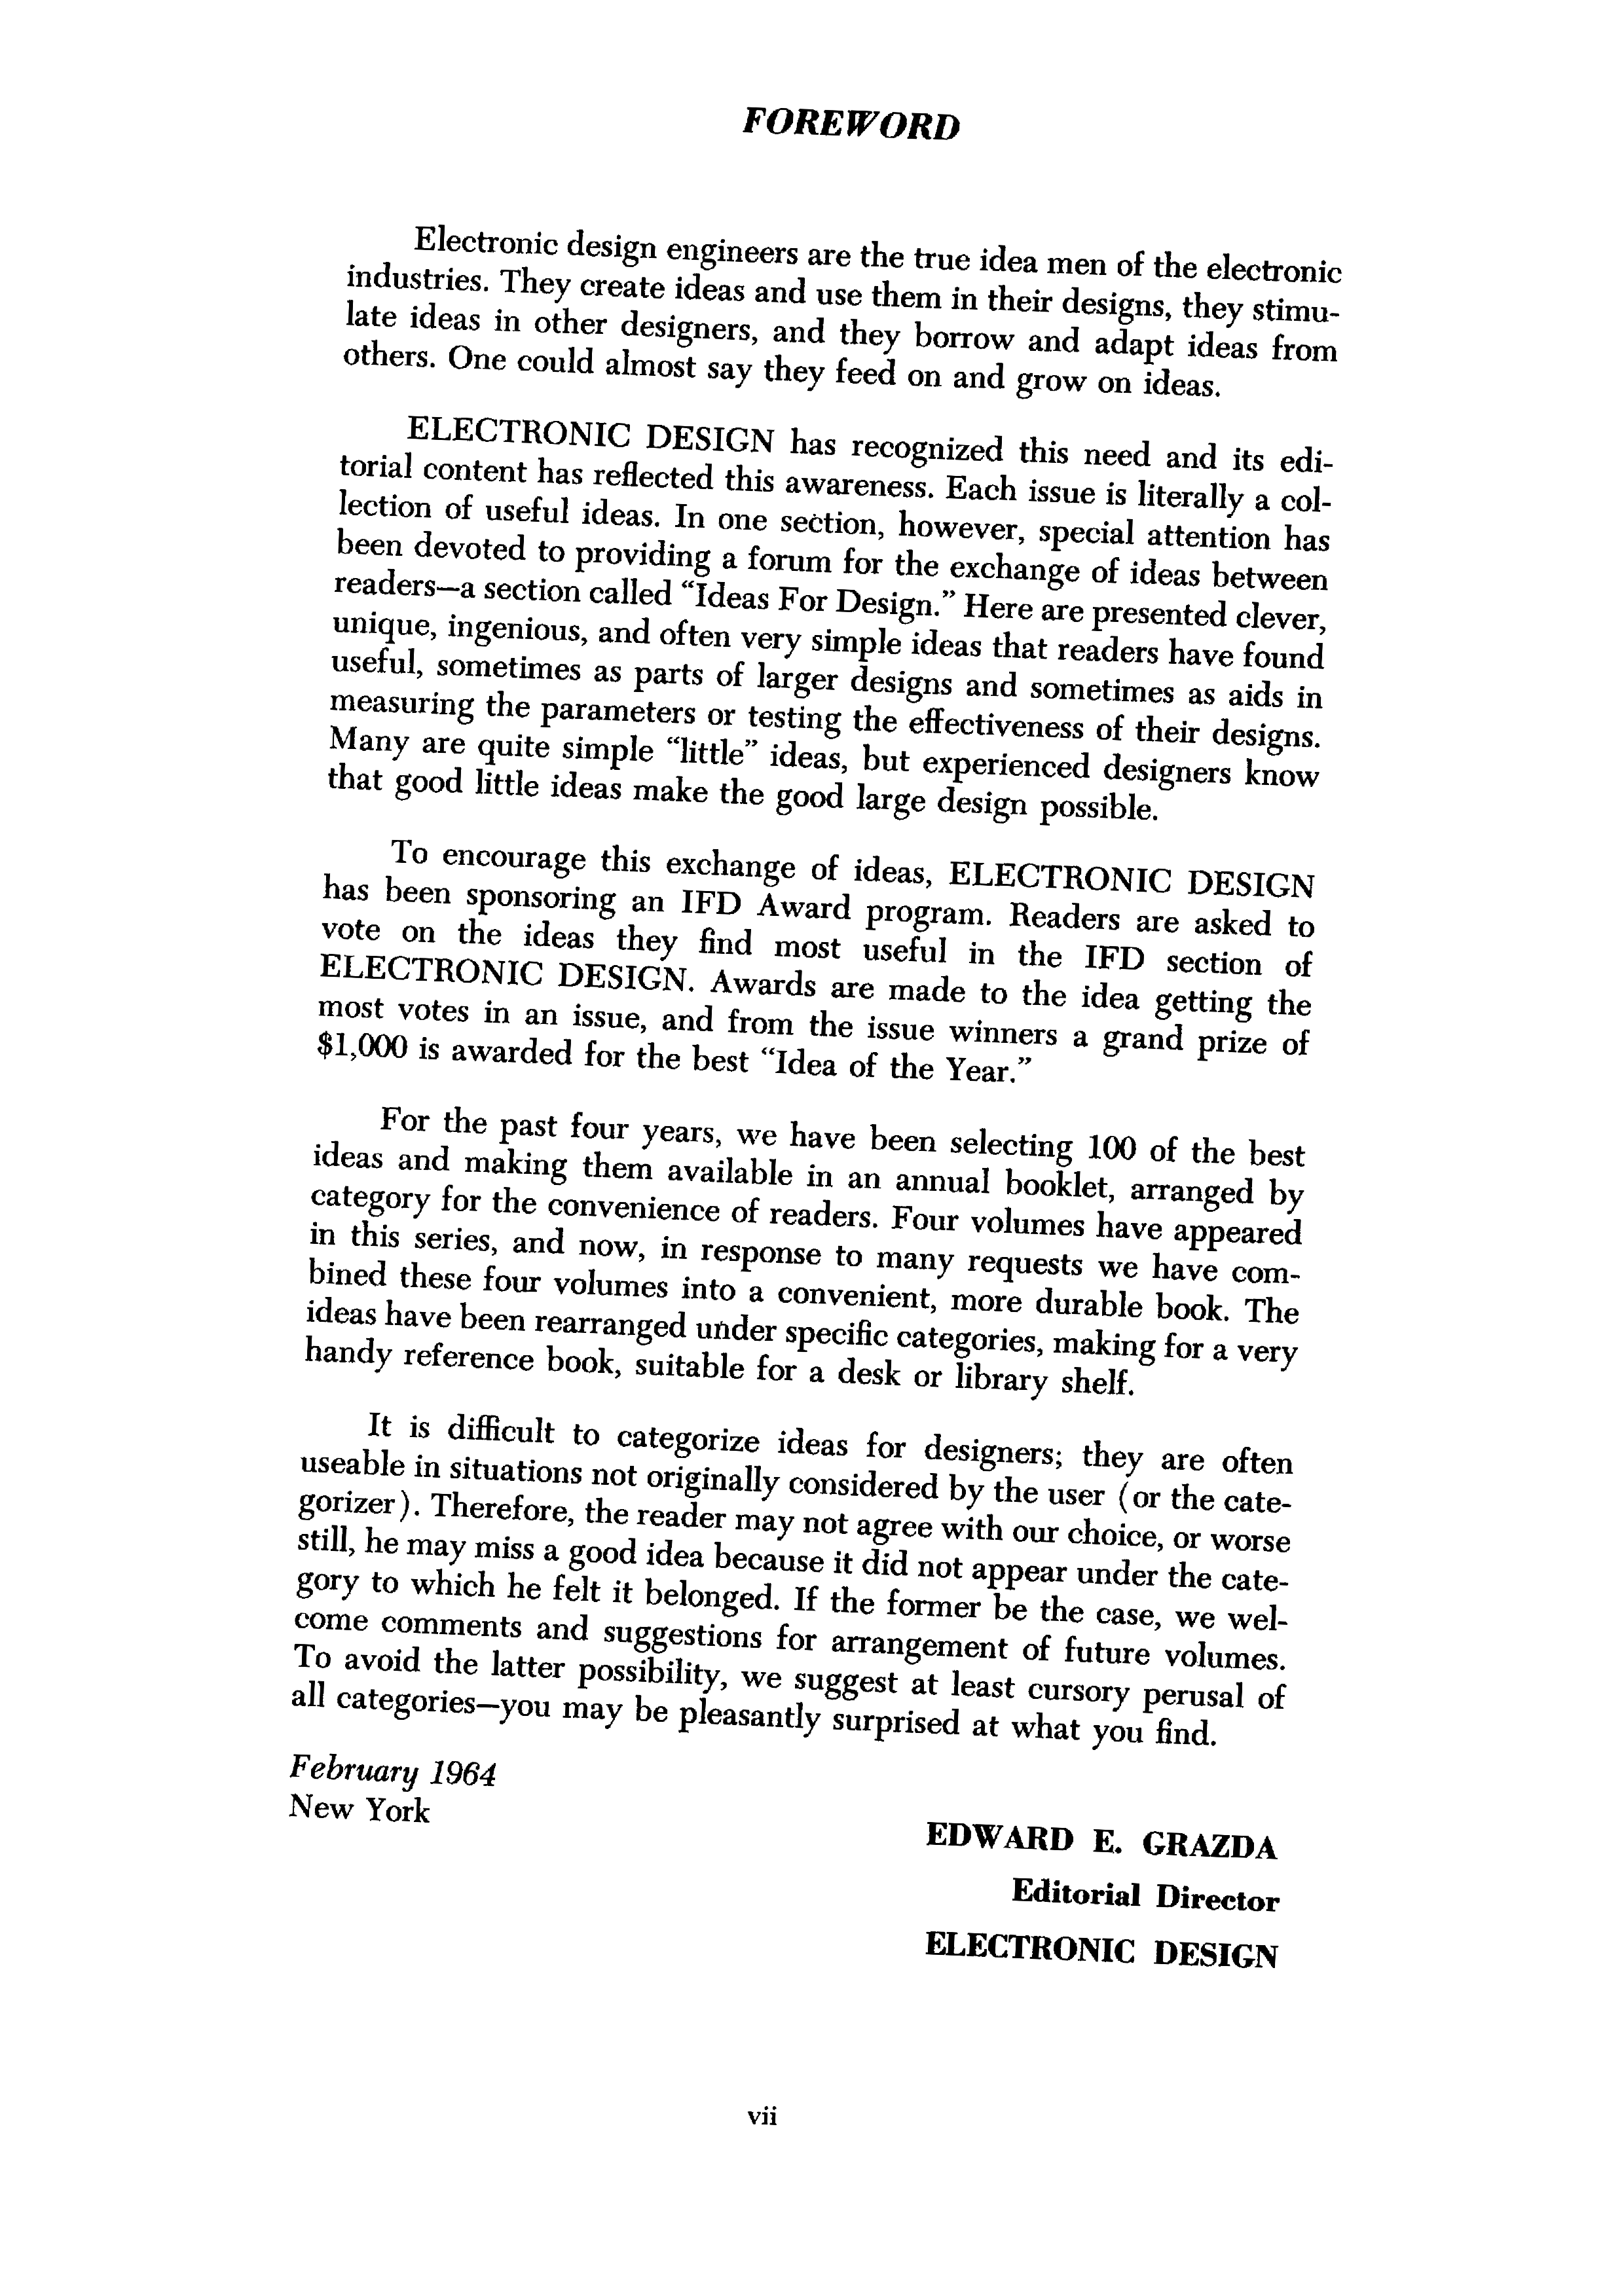

In [7]:
import pkg_resources
rotatedPDF = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/rotated/400/400_rot.pdf')
pdf_rotated_df = spark.read.format("binaryFile").load(rotatedPDF).cache()

display_pdf(pdf_rotated_df)

## Run OCR pipelines

In [8]:
result = pipeline(False).transform(pdf_rotated_df).cache()
corrected_result = pipeline(True).transform(pdf_rotated_df).cache()

## Display results

In [9]:
result.select("pagenum","text", "confidence").show()

+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|FOREWORD

Electro...|95.71951103210449|
+-------+--------------------+-----------------+



### Display recognized text without skew correction

In [10]:
##disableNBVAL_CHECK_OUTPUT
print("\n".join([row.text for row in result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know

that good little ideas make the good large design possible.

To encourage this exchange of ideas, ELECTRONIC DESIGN
has been sponsoring an IFD Award program. Readers are asked to
vote on the ideas they find most useful in the IFD section of

most votes in an issue, and from the issue winners a grand prize of
$1,000 is awarded for the best “Idea of the Year.”

For the past four years, we have been selecting 100 of the best
ideas and making them available in an annual booklet, arranged by

It is difficul

### Display results with skew correction

In [11]:
#disableNBVAL_CHECK_OUTPUT
print("\n".join([row.text for row in corrected_result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-
lection of useful ideas. In one section, however, special attention has
been devoted to providing a forum for the exchange of ideas between
readers—a section called “Ideas For Design.” Here are presented clever,
unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know
that good little ideas make the good large design possible.

To encourage this exchange of id

### Compute score and compare
Read original text and calculate scores for both results.

In [12]:
# disableNBVAL_CHECK_OUTPUT
detected = "\n".join([row.text for row in result.collect()])
corrected_detected = "\n".join([row.text for row in corrected_result.collect()])
# read original text
rotated_text_file = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/rotated/400.txt')
pdf_rotated_text = open(rotated_text_file, "r").read()
# compute scores
detected_score = score(pdf_rotated_text, detected)
corrected_score = score(pdf_rotated_text, corrected_detected)
# print scores
print("Score: {0}".format(detected_score))
print("Score with skew correction: {0}".format(corrected_score))

Score: 0.7278876170655567
Score with skew correction: 0.995067817509248


## Display original images

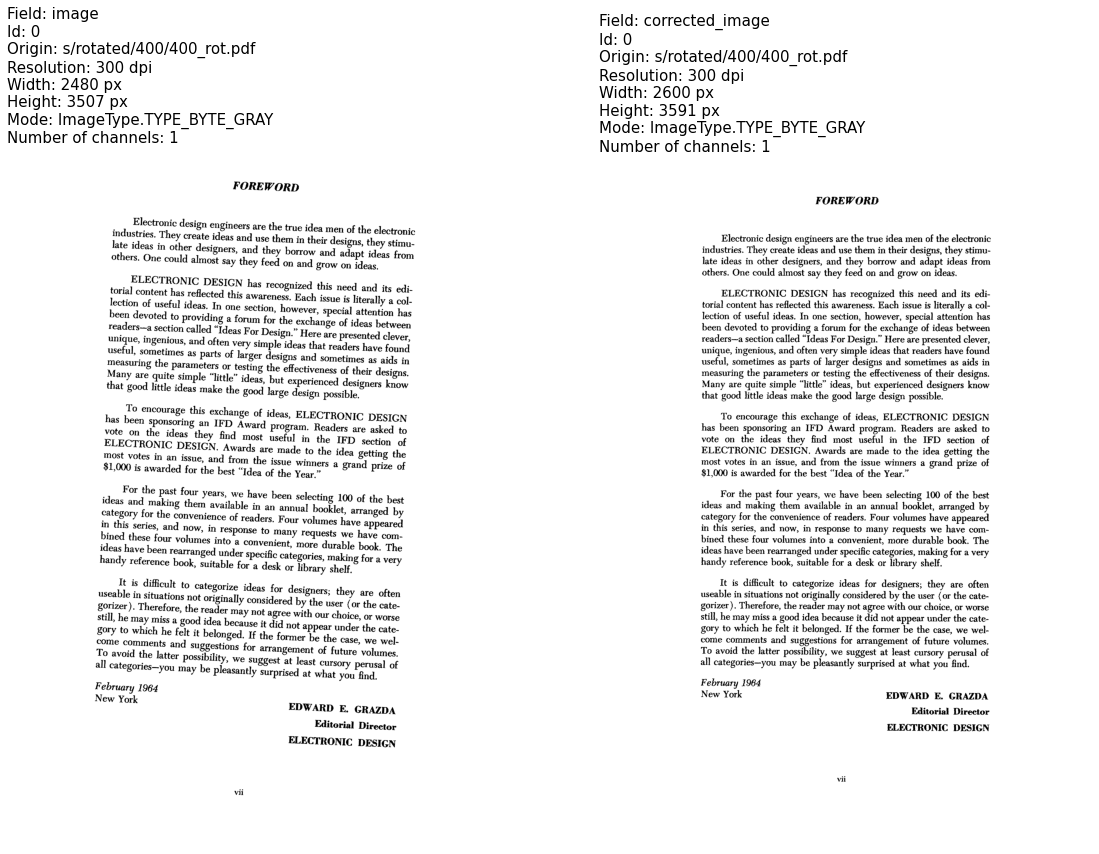

In [13]:
display_images_horizontal(corrected_result, "image,corrected_image")